# Setup

## Import Library

# Cek GPU

In [3]:
import os
import asyncio
import importlib
import time
import shutil
import random
import matplotlib.pyplot as plt
import pandas as pd
import numpy as np
from IPython.core.interactiveshell import InteractiveShell
from PIL import Image
from collections import Counter
from sklearn.metrics import confusion_matrix, ConfusionMatrixDisplay
from datetime import datetime
from sklearn.model_selection import KFold
from sklearn.metrics import classification_report

import torch
import torchvision.models as models

In [4]:
print(torch.cuda.is_available())

True


# EDA

## Jumlah data

In [9]:
def count_images_in_folder(folder_path):
    """Menghitung jumlah gambar dalam folder dan subfolder."""
    count = 0
    for root, dirs, files in os.walk(folder_path):
        count += len([f for f in files if f.endswith(('.jpg', '.jpeg', '.png'))]) 
    return count

# Path ke folder datasets
training_path = "datasets/training"
testing_path = "datasets/testing"

# Hitung jumlah gambar di folder training
training_count = count_images_in_folder(training_path)
print(f"Jumlah gambar di folder training: {training_count}")

# Total jumlah gambar di folder testing
total_testing_count = count_images_in_folder(testing_path)
print(f"Jumlah gambar di folder testing: {total_testing_count}")

Jumlah gambar di folder training: 7354
Jumlah gambar di folder testing: 1646


## Distribusi datasets

Distribusi dataset untuk training: {'print': 2450, 'real': 2264, 'replay': 2640}


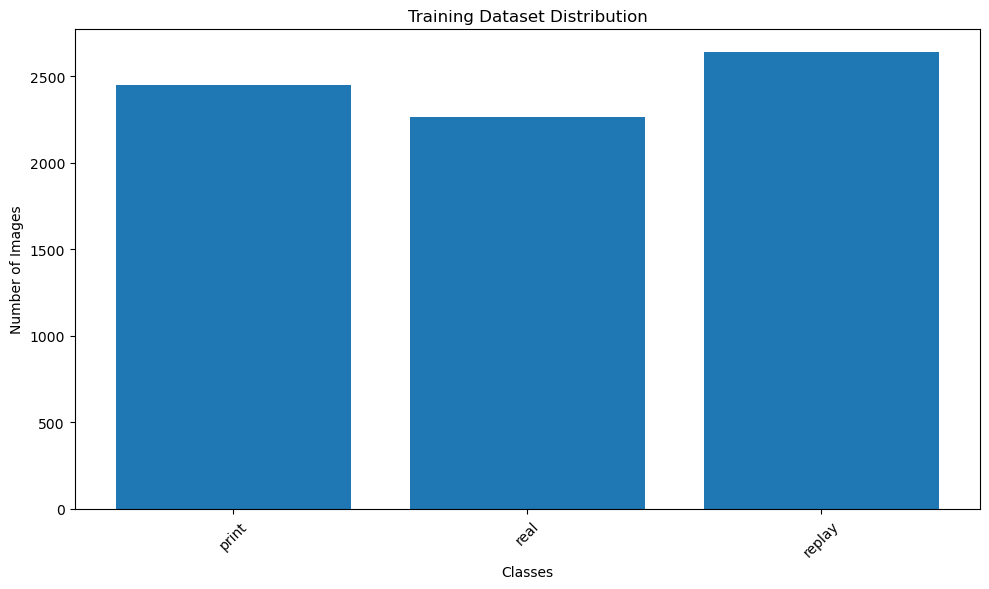

Distribusi dataset untuk testing: {'print': 550, 'real': 736, 'replay': 360}


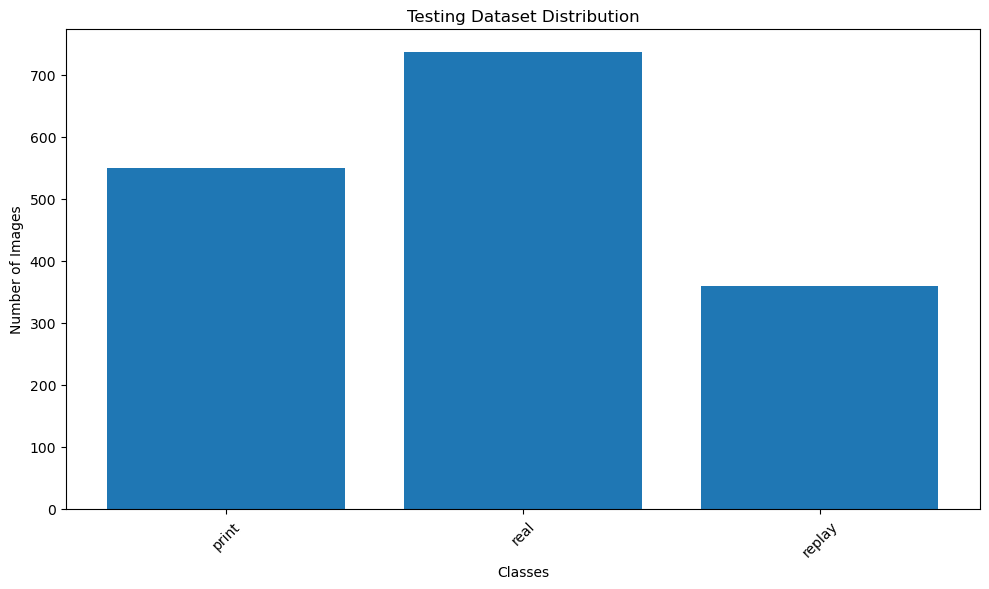

In [10]:
def count_images_in_classes(folder_path):
    """Menghitung jumlah gambar dalam setiap kelas di folder."""
    class_counts = {}
    for class_folder in os.listdir(folder_path):
        class_path = os.path.join(folder_path, class_folder)
        if os.path.isdir(class_path):  # Pastikan hanya menghitung folder (kelas)
            class_counts[class_folder] = len([
                f for f in os.listdir(class_path) if f.endswith(('.jpg', '.jpeg', '.png'))
            ])
    return class_counts

def plot_distribution(class_counts, title):
    """Menampilkan distribusi dataset menggunakan grafik batang."""
    classes = list(class_counts.keys())
    counts = list(class_counts.values())

    plt.figure(figsize=(10, 6))
    plt.bar(classes, counts)
    plt.xlabel('Classes')
    plt.ylabel('Number of Images')
    plt.title(title)
    plt.xticks(rotation=45)
    plt.tight_layout()
    plt.show()

# Path ke folder training dan testing
training_path = "datasets/training"
testing_path = "datasets/testing"

# Hitung distribusi kelas untuk training
training_class_counts = count_images_in_classes(training_path)
print(f"Distribusi dataset untuk training: {training_class_counts}")
plot_distribution(training_class_counts, "Training Dataset Distribution")

# Hitung distribusi kelas untuk testing
testing_class_counts = count_images_in_classes(testing_path)
print(f"Distribusi dataset untuk testing: {testing_class_counts}")
plot_distribution(testing_class_counts, "Testing Dataset Distribution")

## Preview datasets

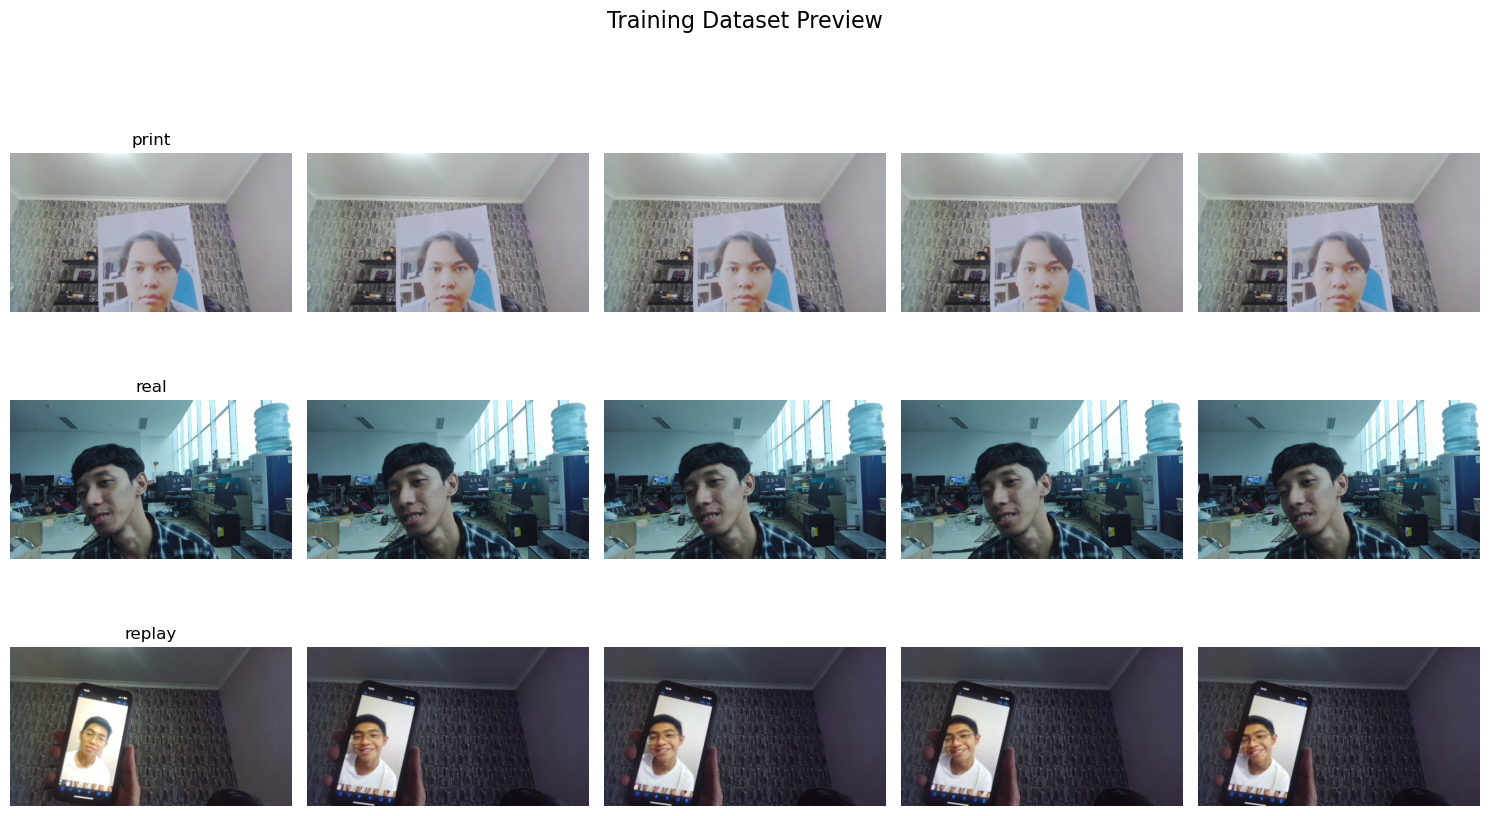

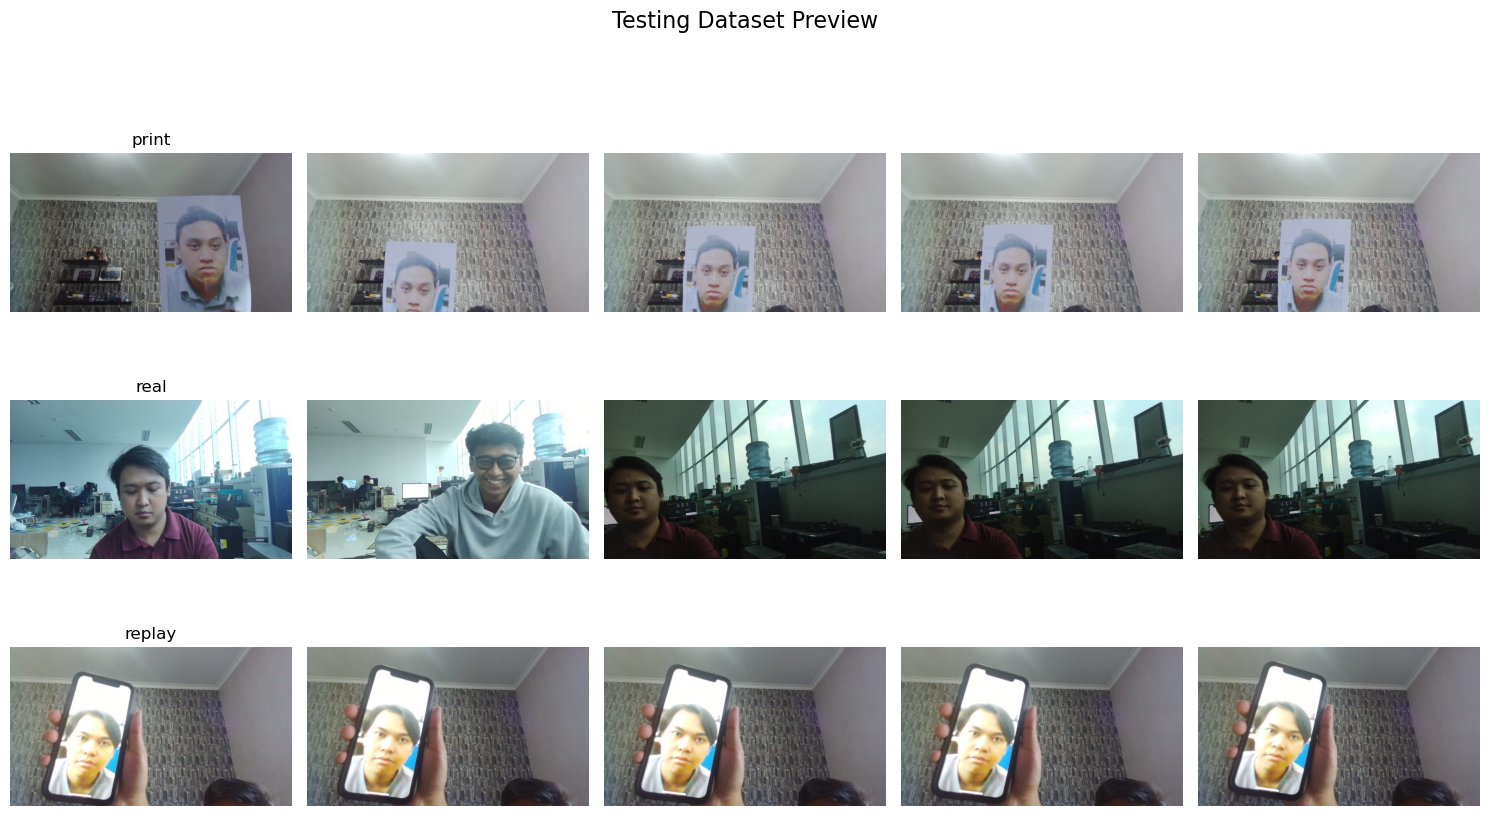

In [11]:
def preview_images(folder_path, title, samples_per_class=5):
    classes = [d for d in os.listdir(folder_path) if os.path.isdir(os.path.join(folder_path, d))]
    num_classes = len(classes)

    # Setup grid untuk menampilkan gambar
    fig, axes = plt.subplots(num_classes, samples_per_class, figsize=(samples_per_class * 3, num_classes * 3))
    fig.suptitle(title, fontsize=16)

    for i, cls in enumerate(classes):
        class_path = os.path.join(folder_path, cls)
        images = [f for f in os.listdir(class_path) if f.endswith(('.jpg', '.jpeg', '.png'))]
        sample_images = images[:samples_per_class]  # Ambil sejumlah gambar untuk preview

        for j in range(samples_per_class):
            ax = axes[i, j] if num_classes > 1 else axes[j]  # Jika hanya 1 kelas, axes menjadi 1D
            ax.axis('off')

            if j < len(sample_images):  # Jika ada gambar yang cukup
                img_path = os.path.join(class_path, sample_images[j])
                img = Image.open(img_path)
                ax.imshow(img)
                ax.set_title(cls if j == 0 else "")

    plt.tight_layout()
    plt.subplots_adjust(top=0.9)
    plt.show()

# Path ke folder training dan testing
training_path = "datasets/training"
testing_path = "datasets/testing"

# Preview gambar di folder training
preview_images(training_path, "Training Dataset Preview", samples_per_class=5)

# Preview gambar di folder testing
preview_images(testing_path, "Testing Dataset Preview", samples_per_class=5)

# EfficientNetV2

In [12]:
# Fungsi untuk menghitung jumlah parameter
def count_params(model):
    return sum(p.numel() for p in model.parameters() if p.requires_grad)

# Membuat dictionary untuk setiap model EfficientNetV2 dan menghitung jumlah parameternya
list_models = {
    "EfficientNetV2_Small": models.efficientnet_v2_s(weights='IMAGENET1K_V1'),
    "EfficientNetV2_Medium": models.efficientnet_v2_m(weights='IMAGENET1K_V1'),
    "EfficientNetV2_Large": models.efficientnet_v2_l(weights='IMAGENET1K_V1'),
}

# Menyimpan hasil dalam dictionary
param_counts = {model_name: count_params(model) for model_name, model in list_models.items()}

# Memformat jumlah parameter dengan titik sebagai pemisah ribuan
formatted_param_counts = {model_name: f"{count:,}".replace(",", ".") for model_name, count in param_counts.items()}

# Menampilkan hasil dalam tabel (pandas DataFrame)
param_df = pd.DataFrame(list(formatted_param_counts.items()), columns=["Model", "Parameter Count"])

# Menampilkan tabel
param_df

Downloading: "https://download.pytorch.org/models/efficientnet_v2_s-dd5fe13b.pth" to /home/machi/.cache/torch/hub/checkpoints/efficientnet_v2_s-dd5fe13b.pth
100.0%
Downloading: "https://download.pytorch.org/models/efficientnet_v2_m-dc08266a.pth" to /home/machi/.cache/torch/hub/checkpoints/efficientnet_v2_m-dc08266a.pth
100.0%
Downloading: "https://download.pytorch.org/models/efficientnet_v2_l-59c71312.pth" to /home/machi/.cache/torch/hub/checkpoints/efficientnet_v2_l-59c71312.pth
100.0%


,Model,Parameter Count
0,EfficientNetV2_Small,21.458.488
1,EfficientNetV2_Medium,54.139.356
2,EfficientNetV2_Large,118.515.272


# Swin Transformer

In [15]:
# Fungsi untuk menghitung jumlah parameter
def count_params(model):
    return sum(p.numel() for p in model.parameters() if p.requires_grad)

# Membuat dictionary untuk setiap model Swin Transformer dan menghitung jumlah parameternya
list_models = {
    "Swin-Tiny": models.swin_t(weights="IMAGENET1K_V1"),
    "Swin-Small": models.swin_s(weights="IMAGENET1K_V1"),
    "Swin-Base": models.swin_b(weights="IMAGENET1K_V1")
}

# Menyimpan hasil dalam dictionary
param_counts = {model_name: count_params(model) for model_name, model in list_models.items()}

# Memformat jumlah parameter dengan titik sebagai pemisah ribuan
formatted_param_counts = {model_name: f"{count:,}".replace(",", ".") for model_name, count in param_counts.items()}

# Menampilkan hasil dalam tabel (pandas DataFrame)
param_df = pd.DataFrame(list(formatted_param_counts.items()), columns=["Model", "Parameter Count"])

# Menampilkan tabel
param_df

,Model,Parameter Count
0,Swin-Tiny,28.288.354
1,Swin-Small,49.606.258
2,Swin-Base,87.768.224


# Training

## Variable Global

In [12]:
dataset_path = "datasets/"
save_model_path = "results/best_model/"
result_csv_path = "results/csv/"
image_path = "results/images/"

In [13]:
# Dataset directories
train_dir = os.path.join(dataset_path, "training")
val_dir = os.path.join(dataset_path, "validation")
test_dir = os.path.join(dataset_path, "testing")

# Random seed
random.seed(42)

## Hyperparameter Settings

In [14]:
batch_size = 32
epochs_size = 30
optimizer = "Adam"
dropout_rate = 0.2
learning_rate = 0.001
trainable_percentage = 0.3

## Split Dataset

In [15]:
def count_images_in_folder(folder_path):
    if not os.path.exists(folder_path):
        return 0
    return sum(len(files) for _, _, files in os.walk(folder_path) if files)

# Fungsi untuk melakukan split
def split_training_data(train_dir, val_dir, validation_split=0.1):
    if os.path.exists(val_dir):
        print(f"Folder '{val_dir}' sudah ada. Tidak melakukan split ulang.")
        return

    os.makedirs(val_dir, exist_ok=True)
    
    # Iterasi setiap kelas di folder training
    for class_name in os.listdir(train_dir):
        class_train_path = os.path.join(train_dir, class_name)
        class_val_path = os.path.join(val_dir, class_name)

        if not os.path.isdir(class_train_path):
            continue
        
        os.makedirs(class_val_path, exist_ok=True)

        # Ambil semua file gambar di kelas ini
        all_images = [f for f in os.listdir(class_train_path) if os.path.isfile(os.path.join(class_train_path, f))]
        total_images = len(all_images)

        # Pilih 10% gambar secara acak untuk dipindahkan ke validation
        val_size = int(total_images * validation_split)
        val_images = random.sample(all_images, val_size)

        # Pindahkan gambar ke folder validation
        for img in val_images:
            src_path = os.path.join(class_train_path, img)
            dest_path = os.path.join(class_val_path, img)
            shutil.move(src_path, dest_path)

# Hitung jumlah gambar sebelum split
print("Sebelum split:")
train_count_before = count_images_in_folder(train_dir)
val_count_before = count_images_in_folder(val_dir)
print(f"  Training: {train_count_before} gambar")
print(f"  Validation: {val_count_before} gambar")

# Lakukan split
split_training_data(train_dir, val_dir, validation_split=0.1)

# Hitung jumlah gambar setelah split
print("\nSetelah split:")
train_count_after = count_images_in_folder(train_dir)
val_count_after = count_images_in_folder(val_dir)
print(f"  Training: {train_count_after} gambar")
print(f"  Validation: {val_count_after} gambar")

Sebelum split:
  Training: 7354 gambar
  Validation: 0 gambar

Setelah split:
  Training: 6619 gambar
  Validation: 735 gambar


## Data Augmentation

## Build Model

In [ ]:
def load_base_model(model_name, img_height, img_width, trainable_percentage, skema):
    

    # Build model
    model = build_model(base_model, train_generator.num_classes, dropout_rate)
    
    # Compile model
    compile_model(model, learning_rate)
    
    return model


def build_model(base_model, num_classes,dropout_rate):
    model = models.Sequential([
        base_model,
        layers.GlobalAveragePooling2D(),
        layers.Dense(256, activation='relu'),
        layers.Dropout(dropout_rate),
        layers.Dense(128, activation='relu'),
        layers.Dropout(dropout_rate),
        layers.Dense(num_classes, activation='softmax')
    ])
    return model

def compile_model(model, learning_rate):
    

def train_model(model, train_generator, val_generator, epochs_size):
    start_time = time.time()
    history = model.fit(
        train_generator,
        epochs=epochs_size,
        validation_data=val_generator
    )
    duration = time.time() - start_time
    return history, duration

def evaluate_model(model, test_generator):
    eval_result = model.evaluate(test_generator)
    return eval_result[1] * 100, eval_result[0]

def save_model(model, save_path, timestamp, model_name):
    model_save_path = os.path.join(save_path, f"{model_name}_{timestamp}.keras")
    model.save(model_save_path)
    return model_save_path

def save_results_to_csv(results, csv_save_path):
    df = pd.DataFrame(results)
    if os.path.exists(csv_save_path):
        existing_df = pd.read_csv(csv_save_path)
        df = pd.concat([existing_df, df], ignore_index=True)
    df.to_csv(csv_save_path, index=False)

def plot_training_metrics(history, image_path, timestamp):
    # Accuracy Plot
    plt.figure(figsize=(10, 6))
    plt.plot(history.history['accuracy'], label='Training Accuracy')
    plt.plot(history.history['val_accuracy'], label='Validation Accuracy')
    plt.xlabel('Epochs')
    plt.ylabel('Accuracy')
    plt.legend()
    plt.title('Training and Validation Accuracy')
    plt.savefig(os.path.join(image_path, f"training_accuracy_{timestamp}.png"))
    plt.show()

    # Loss Plot
    plt.figure(figsize=(10, 6))
    plt.plot(history.history['loss'], label='Training Loss')
    plt.plot(history.history['val_loss'], label='Validation Loss')
    plt.xlabel('Epochs')
    plt.ylabel('Loss')
    plt.legend()
    plt.title('Training and Validation Loss')
    plt.savefig(os.path.join(image_path, f"training_loss_{timestamp}.png"))
    plt.show()

def plot_confusion_matrix(model, test_generator, image_path, timestamp):
    y_true = test_generator.classes
    y_pred = np.argmax(model.predict(test_generator), axis=1)
    cm = confusion_matrix(y_true, y_pred, labels=np.arange(len(test_generator.class_indices)))

    fig, ax = plt.subplots(figsize=(12, 8))
    disp = ConfusionMatrixDisplay(confusion_matrix=cm, display_labels=list(test_generator.class_indices.keys()))
    disp.plot(cmap='Blues', xticks_rotation='vertical', ax=ax)

    plt.title('Confusion Matrix', fontsize=16)
    plt.tight_layout()
    confusion_matrix_path = os.path.join(image_path, f"confusion_matrix_{timestamp}.png")
    fig.savefig(confusion_matrix_path, bbox_inches='tight', dpi=300)
    plt.show()
    plt.close(fig)
    return confusion_matrix_path

def run_training(model):
    
    # Train model
    history, training_duration = train_model(model, train_generator, val_generator, epochs_size)
    
    # Evaluate model
    test_accuracy, test_loss = evaluate_model(model, test_generator)
    
    # Save model
    timestamp = datetime.now().strftime("%Y-%m-%d %H:%M:%S")
    save_model(model, save_model_path, timestamp,model_name)
    
    # Save results
    results = {
        "Timestamp": [timestamp],
        "Model": [model_name],
        "Skema":[skema],
        "Batch Size": [batch_size],
        "Epochs": [epochs_size],
        "Training Accuracy": [max(history.history['accuracy']) * 100],
        "Validation Accuracy": [max(history.history['val_accuracy']) * 100],
        "Testing Accuracy": [test_accuracy],
        "Training Loss": [min(history.history['loss'])],
        "Validation Loss": [min(history.history['val_loss'])],
        "Testing Loss": [test_loss],
        "Training Duration (seconds)": [training_duration],
        "Training Duration (minutes)": [f"{training_duration / 60:.2f}"],
        "Trainable Percentage": [trainable_percentage_modifikasi * 100 if "Modifikasi" in model_name else trainable_percentage * 100],
        "Total Parameter": [f"{model.count_params():,}".replace(",", ".")]
    }
    save_results_to_csv(results, os.path.join(result_csv_path, "training_results_runpod.csv"))

    show_classification_report(model, test_generator, result_csv_path, timestamp)

    return history, image_path, timestamp, model, training_duration, test_accuracy

def plot_history(history, image_path, timestamp, model, training_duration, test_accuracy):
    # Plot metrics
    plot_training_metrics(history, image_path, timestamp)
    
    # Plot confusion matrix
    confusion_matrix_path = plot_confusion_matrix(model, test_generator, image_path, timestamp)
    

def show_classification_report(model, test_generator, save_path, timestamp):
    y_true = test_generator.classes
    y_pred = np.argmax(model.predict(test_generator), axis=1)
    class_labels = list(test_generator.class_indices.keys())

    print("Classification Report:\n", classification_report(y_true, y_pred, target_names=class_labels))

## Train Model

### EfficientNet V2 Small

### EfficientNet V2 Medium

### EfficientNet V2 Large

### Swin Transformer Tiny

### Swin Transformer Small

### Swin Transformer Base